# <u><center>Project 2 Part 5 Core
- Authored by: Eric N. Valdez
- Date: 4/6/2024

## `Sentiment Analysis and Rating Prediction of Moving Reviews`

### <u>Overview:
- This project is an extension of the movies porject from Enricment. This portion focuses on applying Natural Language Processing (NLP) techniques to analyze a database of movie reviews.
- Students will leverage NLP tools such as NLTK, Spacy, WordCloud, and Scikit-Learn to explore, analyze, and model text data. The ultimate goal is to establish a relationship between the textual content of the reviews and their associated ratings and subsequently predict these ratings.

### <u>Dataset: TMDB Movie Reviews
<center> <img src="Data-NLP/Images/IMDB.png">

#### [TMDB Movie Reviews](https://drive.google.com/file/d/1vLUzSYleJXqsjNMsq76yTQ5fmNlSHFJI/view). Ratings Range from 1 to 10</center>
- Gathering through `tmdbsimple` pyhton wrapper for the TMDB API. To legally cite TMDB, please follow their attribution requirements, which we have [summarized here](https://docs.google.com/document/d/1LzFQDulDdQjiMuZ8sBYeDbHnN62ZWjFU_xt_4eSwVIw/edit).

# <u>Imports:

In [1]:
import re
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import numpy as np
import nltk


from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Increase column width
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_colwidth',300)


# <u> Custom Functions:

In [2]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts

In [3]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [5]:
# import matplotlib.pyplot as plt
# ax = dist.plot(20, show=False)
# ax.set_title('Number of Occurances of Top 20 Words')
# ax.grid(False)
# plt.tight_layout()
# plt.savefig('frequency_distribution.png')

In [6]:
def preprocess_doc(doc, remove_stopwords=True, remove_punct=True, use_lemmas=False):
    """Temporary Fucntion - for Education Purposes (we will make something better below)
    """
    tokens = [ ]
    for token in doc:
        # Check if should remove stopwords and if token is stopword
        if (remove_stopwords == True) and (token.is_stop == True):
            # Continue the loop with the next token
            continue
    
        # Check if should remove stopwords and if token is stopword
        if (remove_punct == True) and (token.is_punct == True):
            continue
    
        # Check if should remove stopwords and if token is stopword
        if (remove_punct == True) and (token.is_space == True):
            continue
    
        ## Determine final form of output list of tokens/lemmas
        if use_lemmas:
            tokens.append(token.lemma_.lower())
        else:
            tokens.append(token.text.lower())
    return tokens

# `Tasks`
## 0) <u>Update Your Project 2 Repo
- Create a new `Data-NLP/` folder in your project 2 repository
- Add the dowloaded review to this new `Data-NLP/` folder.
- Make sure you have an `` folder. If <u>not</u>, create one.

## 1) <u>Data Preprocessing 
- `Load and Inspect the dataset`
    - How many reviews?
    - What does the distribution of ratings look like?
    - Any Null values?
- `Use the rating column to create a new` <u>`target column`</u> `with 2 groups: high-rating and low-rating groups`
    - We recommend defining 'High-rating' reviews as any review with a rating >=9; and 'Low-Rating' reviews as any review with a rating <=4.
    - The middel ratings between 4 and 9 will be excluded from the analysis.
    - You may use an alternative definition for High & Low reviews, but justify your choice in your notebook/readme
- `Utilize NLTK & SpaCy for basic text processing including:`
    - Removing stopwards
    - Tokenization
    - Lemmatization
    - `TIPS:`
        - Be sure to creat a custom NLP Object & disable the named entity recognizer. Otherwise, processing will take a very long time!
        - **You will want to create several versions of the data, lemmatized, tolkenized, lemmatized joined back to one string per review, and tokenized joined back to one string per review.** This will be useful for different analysis and modeling techniques.
- `NOTE:`you may find some artifacts during your EDA e.g. HTML code like `"href"`. You are allowed to drop rows from the dataset after identifying problematic trends in some of the texts. `(Hint: Remember df[col].str.contains)`
- <u>Save your processed data frame in a `joblib` file saved in the `Data-NLP/` folder for future modeling. 

In [7]:
# Load the Data
mr = 'Data-NLP/movie_reviews_v2.csv'
df = pd.read_csv(mr, index_col='movie_id')
df.head()

,review_id,imdb_id,original_title,review,rating
movie_id,,,,,
843,64ecc16e83901800af821d50,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0
7443,57086ff5c3a3681d29001512,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
7443,5bb5ac829251410dcb00810c,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0
7443,5f0c53a013a32000357ec505,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0
7443,64ecc027594c9400ffe77c91,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8650 entries, 843 to 575264
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   imdb_id         8650 non-null   object 
 2   original_title  8650 non-null   object 
 3   review          8650 non-null   object 
 4   rating          7454 non-null   float64
dtypes: float64(1), object(4)
memory usage: 405.5+ KB


Cleaing the data 

In [9]:
# Checking for duplicates
df.duplicated().sum()

0

In [10]:
# Checking for null Values
df.isna().sum()

review_id            0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [11]:
# Dropping unnecesary columns
movie_reviews = df.drop(df.columns[[0, 1]], axis=1)
movie_reviews.head()

,original_title,review,rating
movie_id,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0
7443,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0
7443,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0


In [12]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8650 entries, 843 to 575264
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_title  8650 non-null   object 
 1   review          8650 non-null   object 
 2   rating          7454 non-null   float64
dtypes: float64(1), object(2)
memory usage: 270.3+ KB


<u>Creating target column

In [13]:
# Checking what values are in the overall ratings
movie_reviews['rating'].value_counts()

7.0     1576
6.0     1386
8.0     1259
5.0      732
9.0      616
10.0     564
4.0      514
1.0      284
3.0      254
2.0      153
7.5       27
8.5       23
6.5       22
9.5       15
0.5       10
5.5        6
3.5        4
4.5        4
1.5        3
2.5        2
Name: rating, dtype: int64

In [43]:
def create_groups(x):
    if x>=9:
        return "High_rating"
    elif x <=4:
        return "Low_rating"
    else: 
        return None

In [44]:
# Should return high
create_groups(9)

'High_rating'

In [45]:
# Should return low
create_groups(4)

'Low_rating'

In [46]:
# Use the function to create a new "rating" column with groups
movie_reviews['ratings'] = movie_reviews['rating'].map(create_groups)
movie_reviews['ratings'].value_counts(dropna=False)

None           6231
Low_rating     1224
High_rating    1195
Name: ratings, dtype: int64

In [18]:
# Check class balance of 'rating'
movie_reviews['ratings'].value_counts(normalize=True)

Low-rating     0.505994
High-rating    0.494006
Name: ratings, dtype: float64

In [47]:
# Divide documents by sentiment
high = movie_reviews.loc[movie_reviews['ratings'] == 'High_rating']
low = movie_reviews.loc[movie_reviews['ratings'] == 'Low_rating']
print('High Ratings')
display(high.head())
print('Low Ratings')
display(low.head())

High Ratings


,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2621,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ag...",9.0,High_rating,"[okay, admit, bit, easy, grader, come, romantic, comedy, long, witty, likable, character, insult, intelligence, suitable, happy, ending, guess, end, happily, rom, com, see, movie, year, ago, forget, fresh, like, movie, plot, rely, huge, coincidence, story, get, sappy, sentimental, place, predict...","[okay, admit, bit, easy, grader, come, romantic, comedy, long, witty, likable, character, insult, intelligence, suitable, happy, ending, guess, end, happily, rom, com, see, movie, year, ago, forget, fresh, like, movie, plot, rely, huge, coincidence, story, get, sappy, sentimental, place, predict...",okay admit bit easy grader come romantic comedy long witty likable character insult intelligence suitable happy ending guess end happily rom com see movie year ago forget fresh like movie plot rely huge coincidence story get sappy sentimental place predictable religion suit thing suit fine prais...,okay admit bit easy grader come romantic comedy long witty likable character insult intelligence suitable happy ending guess end happily rom com see movie year ago forget fresh like movie plot rely huge coincidence story get sappy sentimental place predictable religion suit thing suit fine prais...
2787,Pitch Black,"All you people are so scared of me. Most days I'd take that as a compliment. But it ain't me you gotta worry about now.\r\n\r\nPitch Black is directed by David Twohy and collectively written by Twohy and Ken and Jim Wheat. It stars Vin Diesel, Radha Mitchell, Cole Hauser, Keith David, Lewis Fitz...",9.0,High_rating,"[people, scared, day, compliment, be, got, to, worry, pitch, black, direct, david, twohy, collectively, write, twohy, ken, jim, wheat, star, vin, diesel, radha, mitchell, cole, hauser, keith, david, lewis, fitz, gerald, claudia, black, rhiana, griffith, music, graeme, revell, cinematography, dav...","[people, scared, day, compliment, be, got, to, worry, pitch, black, direct, david, twohy, collectively, write, twohy, ken, jim, wheat, star, vin, diesel, radha, mitchell, cole, hauser, keith, david, lewis, fitz, gerald, claudia, black, rhiana, griffith, music, graeme, revell, cinematography, dav...",people scared day compliment be got to worry pitch black direct david twohy collectively write twohy ken jim wheat star vin diesel radha mitchell cole hauser keith david lewis fitz gerald claudia black rhiana griffith music graeme revell cinematography david eggby year 2000 awash sci fi movie st...,people scared day compliment be got to worry pitch black direct david twohy collectively write twohy ken jim wheat star vin diesel radha mitchell cole hauser keith david lewis fitz gerald claudia

Low Ratings


,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie
4234,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up...",4.0,Low_rating,"[scream, 3, lackluster, screenplay, unimaginative, kill, leave, film, bore, watch, meta, narrative, trilogy, film, abysmal, plot, film, create, lore, past, movie, seemingly, blue, muddle, continuity, shock, value, add, little, film, feel, force, entire, plot, point, sidney, mother, hollywood, ac...","[scream, 3, lackluster, screenplay, unimaginative, kill, leave, film, bore, watch, meta, narrative, trilogy, film, abysmal, plot, film, create, lore, past, movie, seemingly, blue, muddle, continuity, shock, value, add, little, film, feel, force, entire, plot,

<u>Creating new columns:

In [20]:
# StopWords
from wordcloud import STOPWORDS
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [21]:
# Removing Stopwords
import nltk
from nltk.corpus import stopwords

# Download the stop words list
nltk.download('stopwords')

# Create a list of stop words
stop_words = set(stopwords.words('english'))

# Split the text into words
text = "This is a sample text with stop words."
words = text.split()

# Remove stop words from the list of words
filtered_words = [word for word in words if word not in stop_words]

# Join the remaining words back into a string
filtered_text = " ".join(filtered_words)

# Print the filtered text
print(filtered_text)

This sample text stop words.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
## Download NLTK stopword list
nltk.download('stopwords')

## Load the English stop words.
stop_words = nltk.corpus.stopwords.words('english')
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_lite

In [24]:
movie_reviews['tokens'] = batch_preprocess_texts(
    movie_reviews['review'],
    nlp = nlp_lite,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    batch_size=50,
    n_process=-1)

8650it [02:26, 59.00it/s] 


In [25]:
# # Tolkenize created above instead of seperate
# movie_reviews['tokens'] = movie_reviews['review'].map(lambda doc: doc.lower().split())
movie_reviews.head()

,original_title,review,rating,ratings,tokens
movie_id,,,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en..."
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High-rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,None,"[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]"
7443,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly, course, look, relatively, terrific, impress, pac..."
7443,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0,None,"[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, great, escape, star, trek, love, story, score, cannibalise, write, messrs., korngold, williams, bernstein, add, super, stop, motion, animation, ray, harryhausen, proud, flock..."


In [26]:
# Lemmatization
movie_reviews['lemmatized'] = batch_preprocess_texts(movie_reviews['review'], nlp=nlp_lite,use_lemmas=True)
movie_reviews.head()

8650it [03:12, 45.01it/s] 


,original_title,review,rating,ratings,tokens,lemmatized
movie_id,,,,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en..."
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High-rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,None,"[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]"
7443,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly, course, look, relatively, terrific, impress, pac...","[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly, course, look, relatively, terrific, impress, pac..."
7443,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0,None,"[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, great, escape, star, trek, love, story, score, cannibalise, write, messrs., korngold, williams, bernstein, add, super, stop, motion, animation, ray, harryhausen, proud, flock...","[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movi

In [27]:
# Join list of tokens into a string with spaces between each token
movie_reviews['tokens-joined'] = movie_reviews['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
movie_reviews['lemmas-joined'] = movie_reviews['lemmatized'].map(lambda x: " ".join(x))
movie_reviews.head(3)

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High-rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,None,"[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend


In [ ]:
import joblib
joblib.dump(movie_reviews, 'Data-NLP/processed_data.joblib')

## <u>2) EDA and Visualizaton:
- `Create Word Clouds to visulize the most frequent and significant words in each group`
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g. if the words are common in both groups)
    - <u>Save your WordClouds as .png files in the 'Images/' folder in your repo.</u>
- `Apply NLTK's` <u>`FreqDist`</u> `class to compare the frequency distribution of words in the review groups`
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g. if the words are common in both groups)
    - <u>Save your `FreqDist` as .png files in the 'Images/' folder in your repo.</u>
- `Perform n-grams anaysis (bigrams and trigrams)`
    - Remember, you can use this analysis to identify additional custom stop words to use for EDA. (e.g., if the words are common in both groups)
    - Focus on BiGrams or TriGrams, using NLTK's `BigramCollectionFinder` and BigramAssocMeasures classes(or the Trigram equivalent Finder and Measures) to explore commonly used groups of words for each rating-group.
    - Describe any differences. What do these differences tell you?
    - <u>Save your data frame coparison of the top ngrams for each group as a Markdown Table.</u>
        - You can use the df.to_markdown() method to create a string version of your data frame that can be copied & pasted into a Markdown cell & your readme.
        - <center><img src='Images/1701388160__copymarkdowndataframe.png'></center>
- `Perform sentiment analysis to creat polarity scores according to VADER's sentiment lexicon`
    - Compare the sentiments of high-rating and low-rating texts
    - Compare the compound sentiment sores for high and low-rating reviews.
    - Which review polarity scores don't match the ratings? Why do you think this is?

## `Frequency Distribution`

In [50]:
# Create list of all tokens in all documents
hr_words = high['tokens'].explode().to_list()
lr_words = low['tokens'].explode().to_list()
hr_words[:10]

['guilty',
 'pleasure',
 'personally',
 'love',
 'great',
 'escape',
 'work',
 'see',
 'year',
 'rightfully']

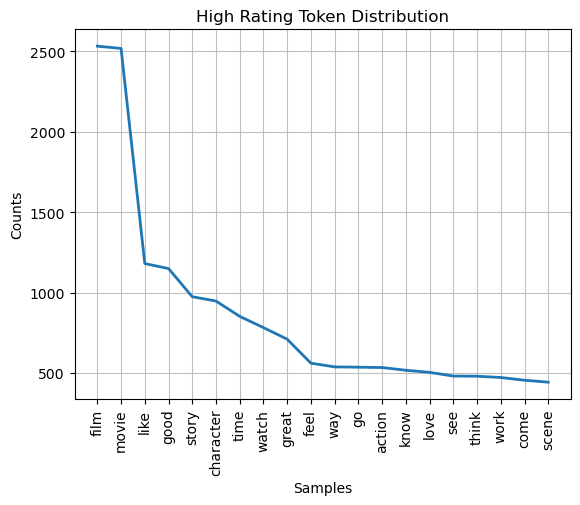

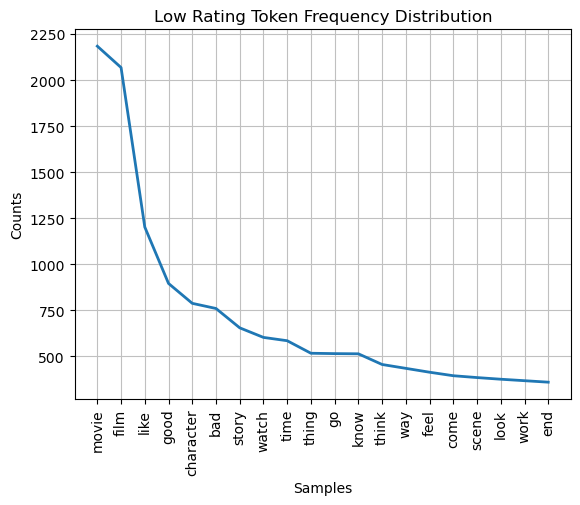

In [51]:
## Instantiate high frequency distribution
high_freq_dist = FreqDist(hr_words)
low_freq_dist = FreqDist(lr_words)

## Plot the distribution
high_freq_dist.plot(20, title='High Rating Token Distribution')

low_freq_dist.plot(20, title='Low Rating Token Frequency Distribution');

In [55]:
# Create a folder for images
import os
os.makedirs("images/", exist_ok=True)

import matplotlib.pyplot as plt

fig = plt.figure()
# Create your plot here

fig.savefig('High and Low Rating Distribution')

<Figure size 640x480 with 0 Axes>

## `Word Clouds:`

In [62]:
# Join the original text for each group
high_rating_joined = " ".join(high['review'])
low_rating_joined = " ".join(low['review'])

In [63]:
def plot_wordclouds(high_cloud, low_cloud, title='Comparing Word Usage'):
    """Plots the wordlcouds for our two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].imshow(high_cloud)
    axes[0].set_title('High Ratings')
    axes[0].axis('off')
    
    axes[1].imshow(low_cloud)
    axes[1].set_title('Low Ratings')
    axes[1].axis('off')
    fig.tight_layout()
    
    fig.suptitle(title,y=1.0, fontsize='xx-large');
    return fig

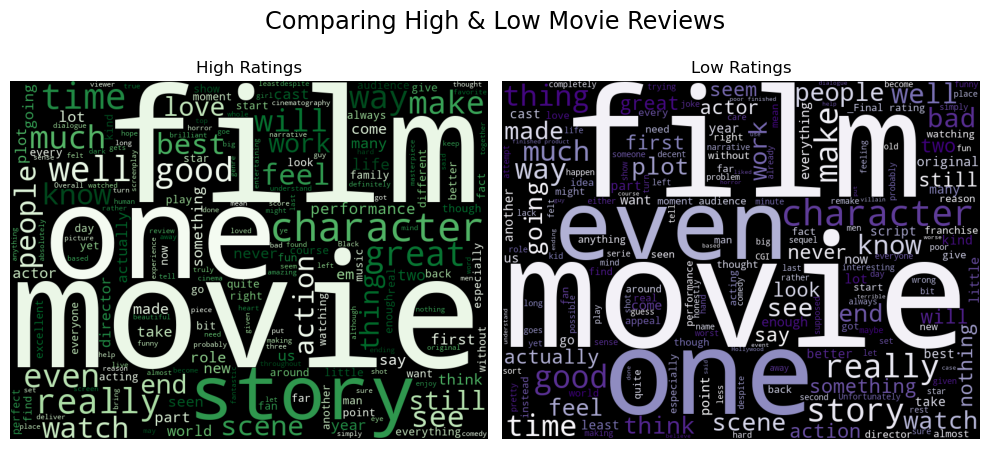

In [64]:
# Generate the WordCloud Images
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_rating_joined)
low_cloud = WordCloud(**wordcloud_kws, colormap='Purples').generate(low_rating_joined)

fig = plot_wordclouds(high_cloud, low_cloud, title="Comparing High & Low Movie Reviews")

# Saving figure for README
fig.savefig('images/wordclouds-movie-reviews.png', dpi=300, bbox_inches='tight', transparent=False)

In [65]:
from wordcloud import STOPWORDS

In [66]:
# Add more custom stopwords for EDA
custom_stopwords = [*STOPWORDS,'use','Hoover','machine','clean','vacuum','carpet','cleaner','one','two','five','star']

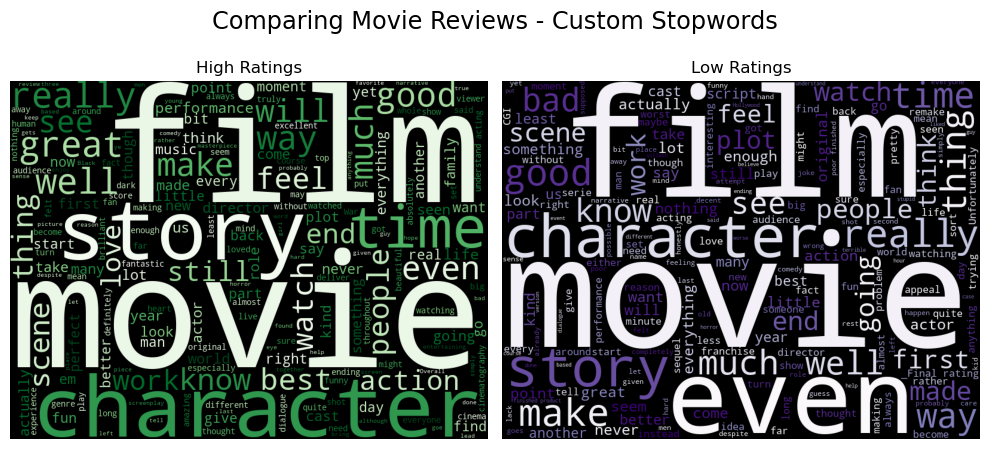

In [69]:
# Generate the WordCloud Images using the custom stopwords
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42,
                     stopwords=custom_stopwords)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_rating_joined)
low_cloud = WordCloud(**wordcloud_kws, colormap='Purples').generate(low_rating_joined)

# ## Plot the Images
fig =  plot_wordclouds(high_cloud,low_cloud, title="Comparing Movie Reviews - Custom Stopwords")

# Save figure
fig.savefig('images/wordclouds-movie-reviews-custom-stop.png', dpi=300,transparent=False, bbox_inches='tight')

In [88]:
fig.savefig('Movie Review Word Cloud')

## `Using Lemmas`

In [71]:
# Join the words for each sentiment
all_high_lemmas = ' '.join(hr_words)
all_low_lemmas = ' '.join(lr_words)
type(all_high_lemmas)

str

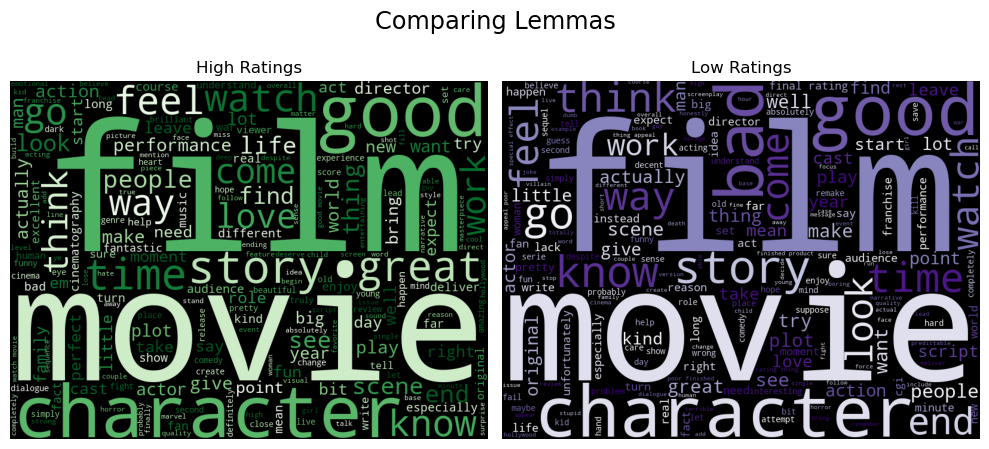

In [72]:
# Generate the WordCloud Images
# wordcloud_kws = dict(min_word_length=2,width=800, height=600, )
hr_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(all_high_lemmas)
lr_cloud = WordCloud(**wordcloud_kws, colormap='Purples').generate(all_low_lemmas)

## Plot the Images
fig = plot_wordclouds(hr_cloud, lr_cloud, title='Comparing Lemmas')

In [90]:
fig.savefig('Images/Comparing Lemmas')

## `N-gram Analysis`
- ### Calculating Frequency Scores

In [73]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

## Create measure classes
measures = BigramAssocMeasures()

## Create collector classes
high_finder = BigramCollocationFinder.from_words(hr_words)
low_finder = BigramCollocationFinder.from_words(lr_words)

In [74]:
# Calculate high-rating ngram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)

# Save as a dataframe
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])


## Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])

## Display the frequency scores
display(high_ngram_scores_df.head(20),low_ngram_scores_df.head(20))

,high ngram,high score
0,"(feel, like)",0.000808
1,"(good, movie)",0.000701
2,"(watch, movie)",0.000644
3,"(good, film)",0.000522
4,"(comic, book)",0.000494
5,"(action, movie)",0.000458
6,"(movie, like)",0.000458
7,"(special, effect)",0.000422
8,"(like, movie)",0.000408
9,"(main, character)",0.000408


,low ngram,low score
0,"(feel, like)",0.001181
1,"(final, rating)",0.001128
2,"(rating, ★)",0.001128
3,"(★, ★)",0.001031
4,"(finished, product)",0.000846
5,"(look, like)",0.000846
6,"(appeal, poor)",0.000837
7,"(poor, finished)",0.000837
8,"(thing, appeal)",0.000837
9,"(★, thing)",0.000837


In [75]:
# Plot Frequency Scores
top_5_ngrams_high = high_ngram_scores_df.set_index("high ngram").head(5)
top_5_ngrams_high

,high score
high ngram,
"(feel, like)",0.000808
"(good, movie)",0.000701
"(watch, movie)",0.000644
"(good, film)",0.000522
"(comic, book)",0.000494


In [76]:
top_5_ngrams_low = low_ngram_scores_df.set_index("low ngram").head(5)
top_5_ngrams_low

,low score
low ngram,
"(feel, like)",0.001181
"(final, rating)",0.001128
"(rating, ★)",0.001128
"(★, ★)",0.001031
"(finished, product)",0.000846


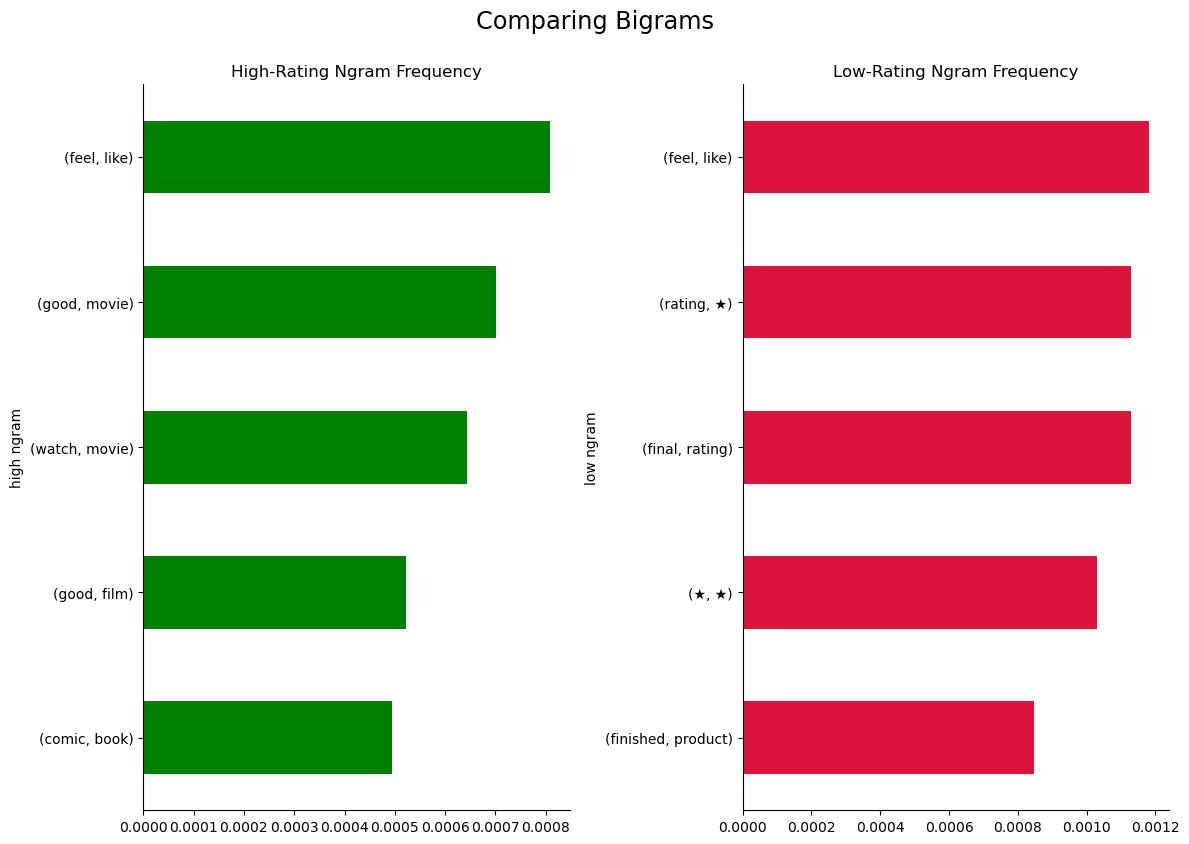

In [77]:
# Visualizing ngram frequency
fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
## Plot the ngram frequencies
top_5_ngrams_high["high score"].sort_values().plot(
    kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
)

top_5_ngrams_low["low score"].sort_values().plot(
    kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
)
# Remove lines from top and right edges (spines)
for ax in axes:
    ax.spines["top"].set_visible(False)  # Remove the top spine
    ax.spines["right"].set_visible(False)  # Remove the right spine

fig.tight_layout()
fig.suptitle("Comparing Bigrams", y=1.05, fontsize="xx-large");

In [82]:
def plot_group_ngrams( low_ngram_scores, high_ngram_scores, 
                       plot_col_low="low score",top_n=5,
                      plot_col_high="high score",figsize=(20, 10),):
    # Get top n ngrams for both groups (set index for easier pandas plotting)
    top_n_ngrams_high = high_ngram_scores.set_index("high ngram").head(top_n)
    top_n_ngrams_low = low_ngram_scores.set_index("low ngram").head(top_n)

    ## Plot the ngram frequencies
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    #
    top_n_ngrams_high[plot_col_high].sort_values().plot(
        kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
    )

    top_n_ngrams_low[plot_col_low].sort_values().plot(
        kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
    )
    for ax in axes:
        ax.spines["top"].set_visible(False)  # Remove the top spine
        ax.spines["right"].set_visible(False)  # Remove the right spine

    fig.tight_layout()
    return fig

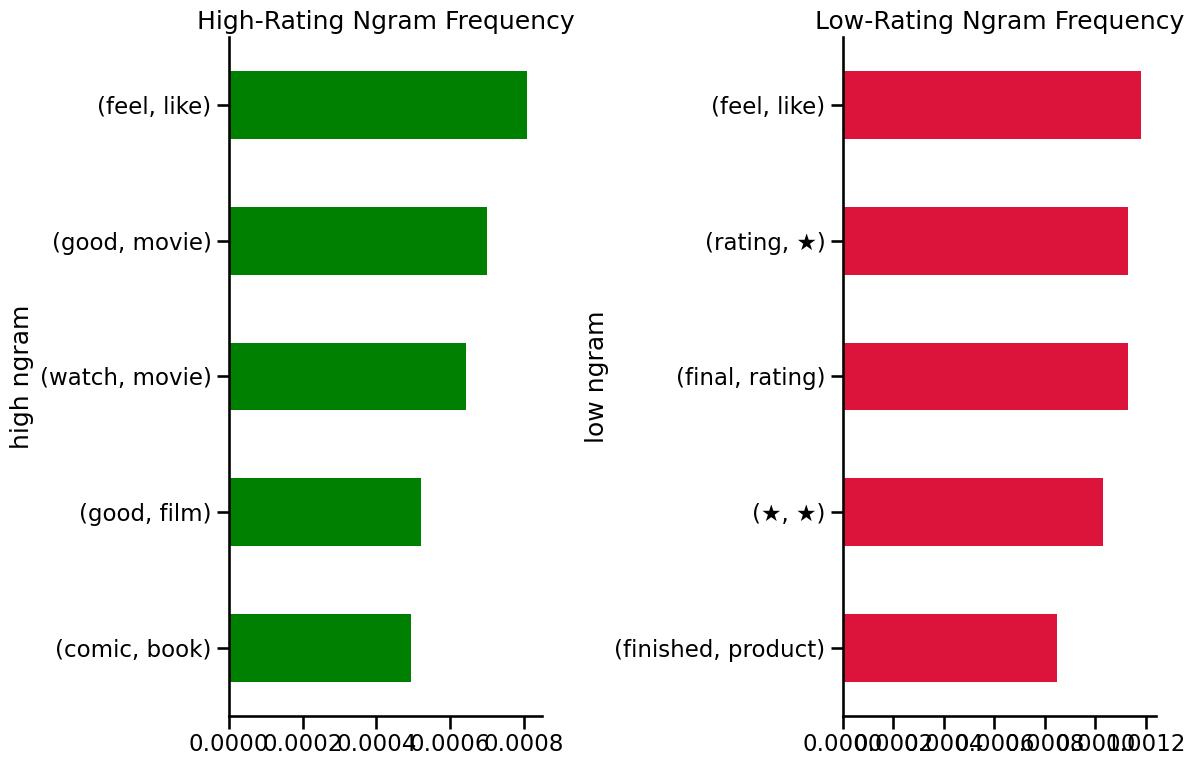

In [81]:
with sns.plotting_context('talk'):
    fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

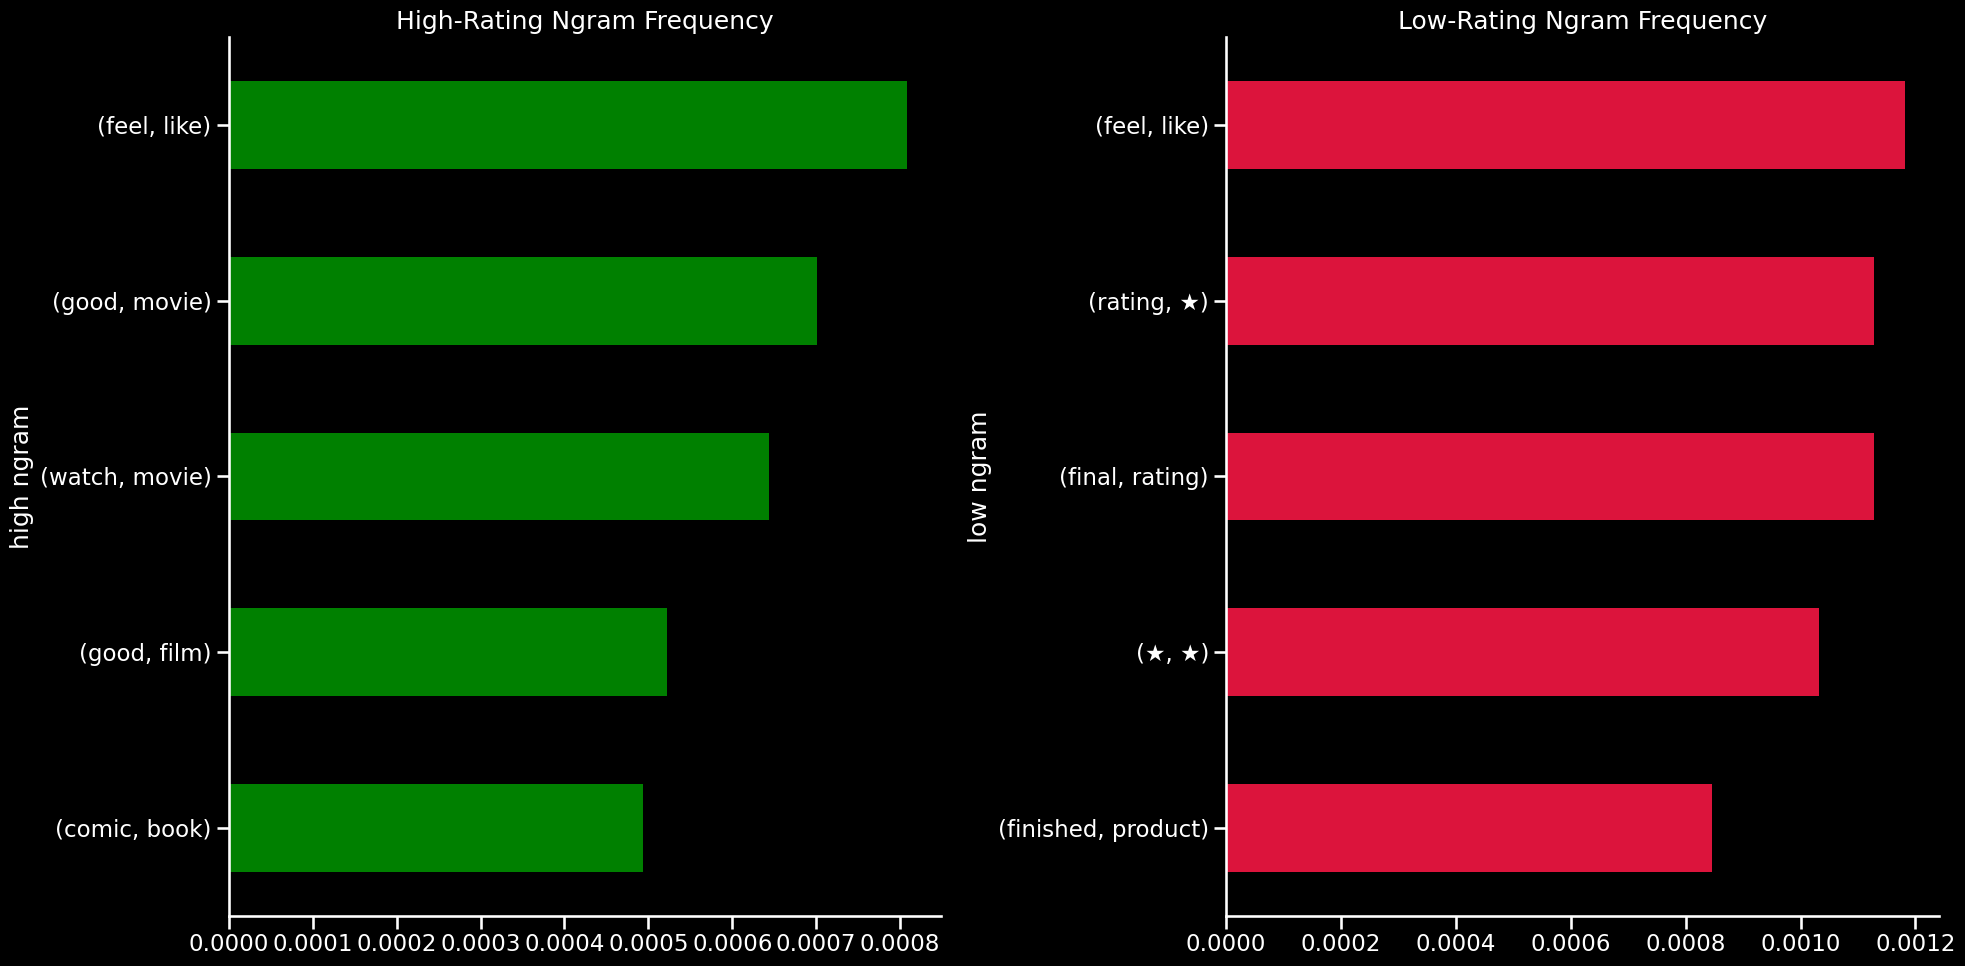

In [83]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

In [91]:
fig.savefig('Images/Top 5 NGrams')

## `Trigrams:`

In [84]:
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

## Create measure classes
measures = TrigramAssocMeasures()

## Create collector classes
high_finder = TrigramCollocationFinder.from_words(hr_words)
low_finder = TrigramCollocationFinder.from_words(lr_words)

In [86]:
# Calculate high-rating trigram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])

# Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])


## Display the frequency scores
display(high_ngram_scores_df.head(5),low_ngram_scores_df.head(5))

,high ngram,high score
0,"(spoiler, free, review)",0.000229
1,"(=, =, =)",0.000200
2,"(review, <, >)",0.000193
3,"(★, ★, ★)",0.000172
4,"(enjoy, read, spoiler)",0.000165


,low ngram,low score
0,"(final, rating, ★)",0.001128
1,"(rating, ★, ★)",0.001014
2,"(appeal, poor, finished)",0.000837
3,"(poor, finished, product)",0.000837
4,"(thing, appeal, poor)",0.000837


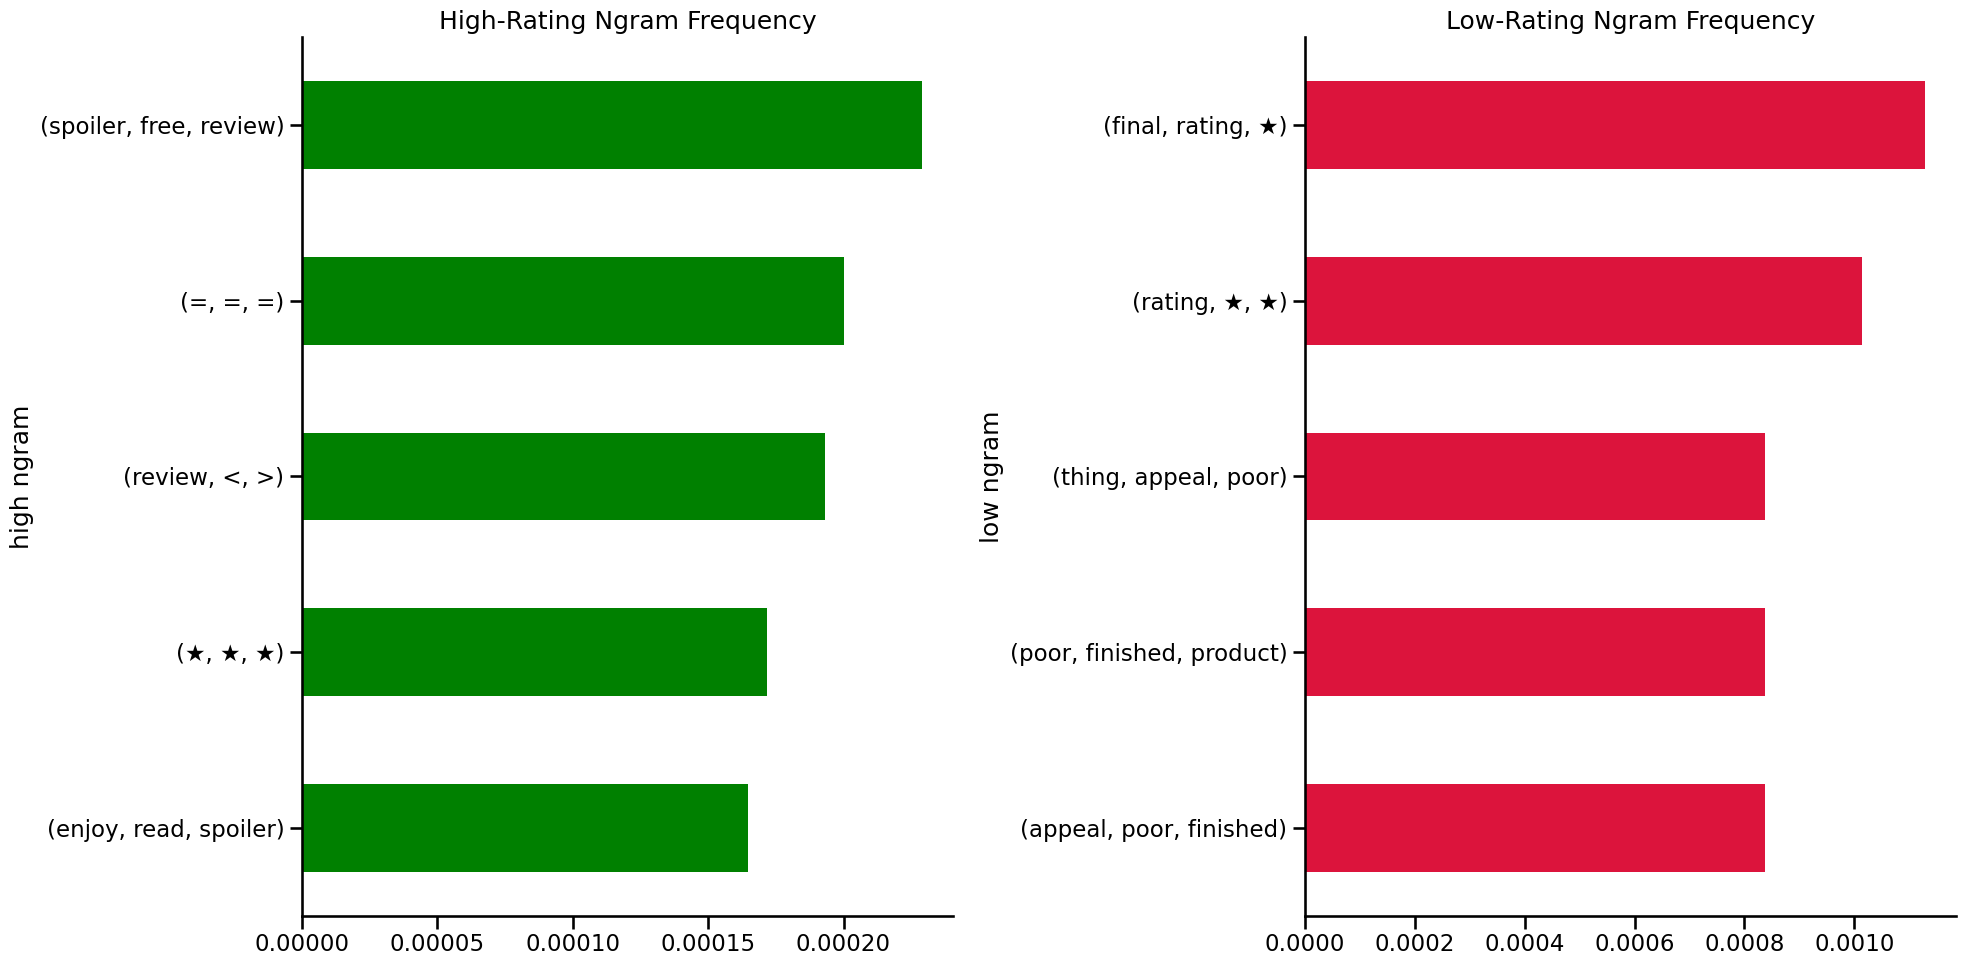

In [87]:
# with plt.style.context(['ggplot','dark_background',]):
with sns.plotting_context('talk'):

    fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

In [92]:
fig.savefig('Images/Top 5 TriGrams')

## <u>3) Evaluation and Reporting:
- `Based on your anlysis, what should someone do (or not do) if they want to make a highly-rated movie?`
    - List 3 things associated with high-rating reviews
    - List 3 things associated with low-rating reviews 
- `Update your project README with a new Section for 'NLP Analysis of Movie Reviews.'`
    - Include what reviews were used (source and what the original rating numbers were b4 they were converted to a categorical target)
    - Include your EDA visualization in your README:
        - One WordCloud comparing both groups
        - 2 FreqDist plots(1 per group)
        - A Markdown table of the Top Ngrams for each group.
    - Your recommendations/conclusions for what to do/not to do make a highly-rated movie 

In [95]:
## Create list of all tokens in all documents
high_words = high['tokens'].explode().to_list()
low_words = low['tokens'].explode().to_list()
low_words[:10]

['underwhelme',
 'straight',
 'bore',
 'course',
 'see',
 'hunt',
 'climb',
 'mountain',
 'harness',
 'impressive']

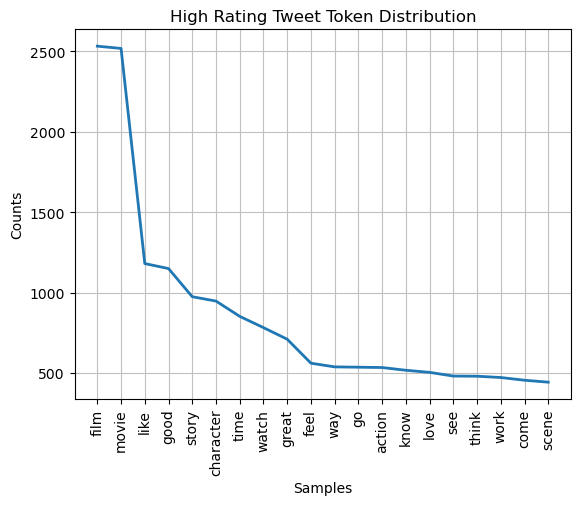

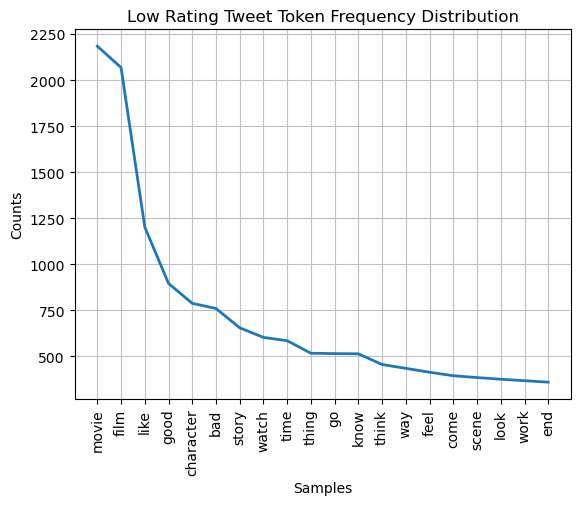

In [96]:
## Instantiate positive frequency distribution
high_freq_dist = FreqDist(high_words)
low_freq_dist = FreqDist(low_words)

## Plot the distribution
high_freq_dist.plot(20, title='High Rating Tweet Token Distribution')

low_freq_dist.plot(20, title='Low Rating Tweet Token Frequency Distribution');

In [97]:
fig.savefig('Images/FreqDist')

## <u>Deliverables:
1. Notebook files for Preprocessing and EDA
2. EDA Images saved in an `"Images"` folder.
3. Update README 